In [1]:
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 5.0)
plt.style.use('ggplot')

This is a rather straightforward example of how to train a linear regression model in a 2D case.
$X$ is a vector with the independent variables and $Y$ with the dependent ones.
In this particular example we synthetically generate points on a linear function while adding noise.

In [2]:
X = np.linspace(0,10,50)
X[:3] # sample of X

array([ 0.        ,  0.20408163,  0.40816327])

In [3]:
np.random.seed(42)
noise = 1.5*(2*np.random.random(len(X)) - 1)
Y = (X + noise)
Y[:3] # sample of Y

array([-0.37637964,  1.55622455,  1.10414509])

We start an instance of a [linear regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model.

In [4]:
regr = linear_model.LinearRegression()

We train it on the synthetic data.

In [5]:
regr.fit(X.reshape(-1,1),Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

The `reshape` above is there due to a warning/error you might be seeing if omitted.

Once trained, the model can be used to predict the values of the points we started with in $X$.
Note, as we are dealing with a linear model, there is no way of ending up with [over-fitting model](https://en.wikipedia.org/wiki/Overfitting).

In [6]:
Y_pred = regr.predict(X.reshape(-1,1))

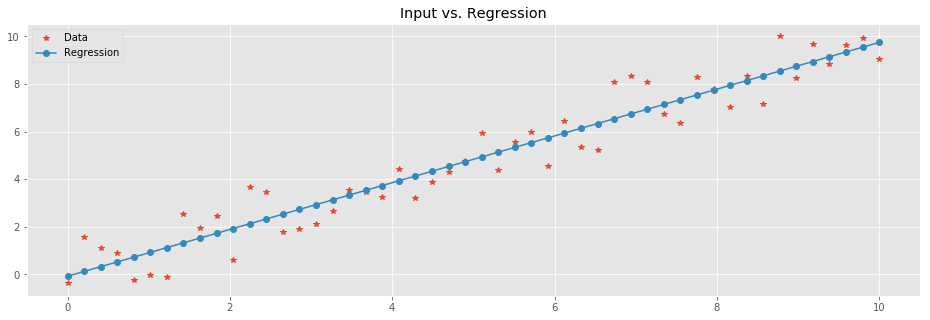

In [7]:
plt.plot(
    X,Y,'*', # Data
    X, Y_pred,'-o' # Regression
)
plt.legend(['Data','Regression'])
plt.title('Input vs. Regression');

Let's look into the result.
The linear function to which we added noise was $y=ax + b$ where the coefficient $a = 1$ and the intercept $b=0$.
We can compute $a$ and $b$ of the trained model.
$a$, a.k.a. the slope, is directly computed by:

In [8]:
(Y_pred[10] - Y_pred[9])/(X[10] - X[9])

0.98216273101406792

It is actually an attribute of the model:

In [9]:
regr.coef_

array([ 0.98216273])

Similarly, the intercept is merely the value of the model for $X=0$:

In [10]:
Y_pred[0]

-0.073041941893555951

And again, this is an attribute of the model:

In [11]:
regr.intercept_

-0.073041941893555951

In the example so far, the noise was uniformly distributed in the $[-1.5,1.5)$ interval.
Next, we'd like to check the relation between the radius ($1.5$ in this case) of the noise and the coefficient/intercept of the model.

In [12]:
def gen_data(size=30, noise_radius=1.5, seed=42):
    X = np.linspace(0,10,size)
    np.random.seed(seed)
    noise = noise_radius*(2*np.random.random(len(X)) - 1)
    Y = (X + noise)
    return X, Y

def train_predict(X, Y):
    regr = linear_model.LinearRegression()
    regr.fit(X.reshape(-1,1),Y)
    Y_pred = regr.predict(X.reshape(-1,1))
    return regr, Y_pred

Next we are going to generate synthetic data sets with growing noise radius.
In each iterations, we will register the coefficient and the intercept of the trained model.

In [13]:
coeff = []
inter = []
rads = np.linspace(0,50,1000)
for rad in rads:
    X, Y = gen_data(noise_radius=rad)
    regr, Y_pred = train_predict(X,Y)
    coeff.append(regr.coef_)
    inter.append(regr.intercept_)

Let's have a look at the behavior of the error between the coefficients and intercepts that we witness and the real ones we used for the generation of the data.

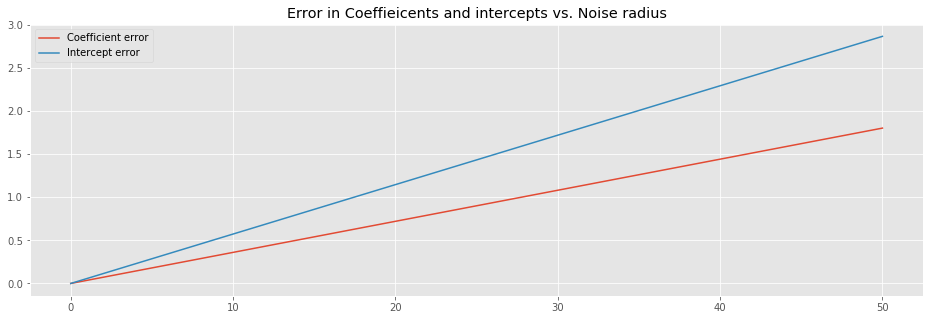

In [14]:
plt.plot(
    rads,np.abs(np.add(-1,coeff)), # we know that the slope we use equals 1
    rads,np.abs(inter)
)
plt.title('Error in Coeffieicents and intercepts vs. Noise radius')
plt.legend(['Coefficient error', 'Intercept error']);

The above image suggest that the error of both the coefficient and the intercept linearly depend on the noise radius.

Formally, the we have samples from a linear function $$y = x + \epsilon$$ where $\epsilon$ is uniform noise.
For each $x_i \in X$ we have a corresponding value $y_i \in Y$.
Our objective is to find $a$ and $b$ such that $y \sim ax +b$.
We do so by minimizing the $L_2$ error $$E(a,b) = \sum_{i=1}^n (y_i - (ax_i+b))^2$$ as a function of $a$ and $b$.
We take partial derivatives and find the minimum:
$$
\left\{ 
\begin{array}{c}
\frac{\partial E}{\partial a} = 0 \\ 
\frac{\partial E}{\partial b} = 0 
\end{array}
\right. 
$$
This turns to be:
$$
\left\{ 
\begin{array}{c}
\sum (y_i - (ax_i +b))x_i = 0 \\ 
\sum (y_i - (ax_i +b)) = 0 
\end{array}
\right. 
$$

From this, we can have a closed formula for $a$ and $b$:
$$
\left\{ 
\begin{array}{c}
a = \frac{X \cdot Y - n \bar{X}\bar{Y}}{X \cdot X - n \bar{X}^2} \\ 
b = \bar{Y} - a \bar{X} 
\end{array}
\right. 
$$
Here, $\bar{X}$ and $\bar{Y}$ denote the mean of $X$ and $Y$, respectively.
Furthermore, $n$ is the number of sample points.
We can now check the closed formulas, and compare them to the coefficient and intercept of the model we tarined:

In [15]:
(np.dot(X,Y)/(len(Y)) - X.mean()*Y.mean())/\
(np.dot(X,X)/len(X) - np.power(X.mean(),2))

-0.8010271422548586

vs.

In [16]:
regr.coef_

array([-0.80102714])

And:

In [17]:
Y.mean() - X.mean()* \
(np.dot(X,Y)/(len(Y)) - X.mean()*Y.mean())/\
(np.dot(X,X)/len(X) - np.power(X.mean(),2))

2.8648629210179717

vs.

In [18]:
regr.intercept_

2.864862921017969

Lastly, the closed formulas above provide good intuition why the error of the model grows linearly.
In the future I will explain this in details.